In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

## Data Preprocessing

In [7]:
df1=pd.read_csv('./data/london.csv', index_col=0)

In [8]:
df1.head()

,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL


In [10]:
df1.shape

(3480, 10)

In [39]:
df2=df1.drop(['Property Name', 'House Type','Postal Code','City/County'], axis='columns')
df2.head()

,Price,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location
0,1675000,2716,5,5,5,Wimbledon
1,650000,814,2,2,2,Clerkenwell
2,735000,761,2,2,2,Putney
3,1765000,1986,4,4,4,Putney
4,675000,700,2,2,2,Putney


In [40]:
df2.isnull().sum()

Price                  0
Area in sq ft          0
No. of Bedrooms        0
No. of Bathrooms       0
No. of Receptions      0
Location             962
dtype: int64

In [41]:
df2.dropna(inplace=True)
df2.isnull().sum()

Price                0
Area in sq ft        0
No. of Bedrooms      0
No. of Bathrooms     0
No. of Receptions    0
Location             0
dtype: int64

##### Price in pounds per unit area in square feet

In [42]:
df2['price_per_sqft']= df2['Price']/df2['Area in sq ft']
df2.head()

,Price,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,price_per_sqft
0,1675000,2716,5,5,5,Wimbledon,616.715758
1,650000,814,2,2,2,Clerkenwell,798.525799
2,735000,761,2,2,2,Putney,965.834428
3,1765000,1986,4,4,4,Putney,888.721047
4,675000,700,2,2,2,Putney,964.285714


## Feature Engineering

how many unique locations are there

In [43]:
print(len(df2['Location'].unique()))

len(df2.Location.unique())

656


656

to see if we can perform feature engineering, such that the number of columns don't increase by too much when we encode categorical features, let's try to introduce some boundary to location feature: for instance, if a given location repeats less than 10 times, discard their value and just label them 'other'

In [44]:
df2.Location=df2.Location.apply(lambda x: x.strip())

location_stats=df2.groupby('Location')['Location'].agg('count').sort_values(ascending=False)

location_stats 

Location
Putney                 126
Battersea               94
Esher                   88
Wandsworth              87
Wimbledon               82
                      ... 
Hanwell                  1
Harrow On The Hill       1
Hartington Road          1
Haverstock Street        1
1 Albert Embankment      1
Name: Location, Length: 576, dtype: int64

how many locations have less than 10 data points

In [45]:
len(location_stats[location_stats<=10])

531

In [46]:
location_stats_lessThan_10=location_stats[location_stats<=10]
location_stats_lessThan_10.head()

Location
Kentish Town            10
Earls Court             10
Knightsbridge           10
Kingston upon Thames    10
Holloway                10
Name: Location, dtype: int64

In [47]:
df2.Location=df2.Location.apply(lambda x: 'other' if x in location_stats_lessThan_10 \
                               else x)

len(df2.Location.unique())

46

## Handling Outliers

In [48]:
df2.price_per_sqft.describe()

count    2518.000000
mean     1050.968979
std       586.443743
min       241.610738
25%       713.234452
50%       902.516708
75%      1184.562336
max      7069.180153
Name: price_per_sqft, dtype: float64

let's define a function that finds mean and standard deviation of prices per location, since different locatoins are likely to have different price ranges, and filter out any data points which are beyond one std

In [49]:
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key, subdf in df.groupby('Location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        cleaned_df=subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out, cleaned_df], ignore_index=True)
    return df_out

In [50]:
df2=remove_pps_outliers(df2)
print(df2.head())
df2.shape

     Price  Area in sq ft  No. of Bedrooms  No. of Bathrooms  \
0   785000            590                1                 1   
1   740000            579                1                 1   
2   750000            580                1                 1   
3  1160000            861                2                 2   
4   750000            579                1                 1   

   No. of Receptions       Location  price_per_sqft  
0                  1  101 Wood Lane     1330.508475  
1                  1  101 Wood Lane     1278.065630  
2                  1  101 Wood Lane     1293.103448  
3                  2  101 Wood Lane     1347.270616  
4                  1  101 Wood Lane     1295.336788  


(1912, 7)

let's visualise distribution of apartament prices per square foot area and see if it resembles Bell's distribution

Text(0, 0.5, 'Count')

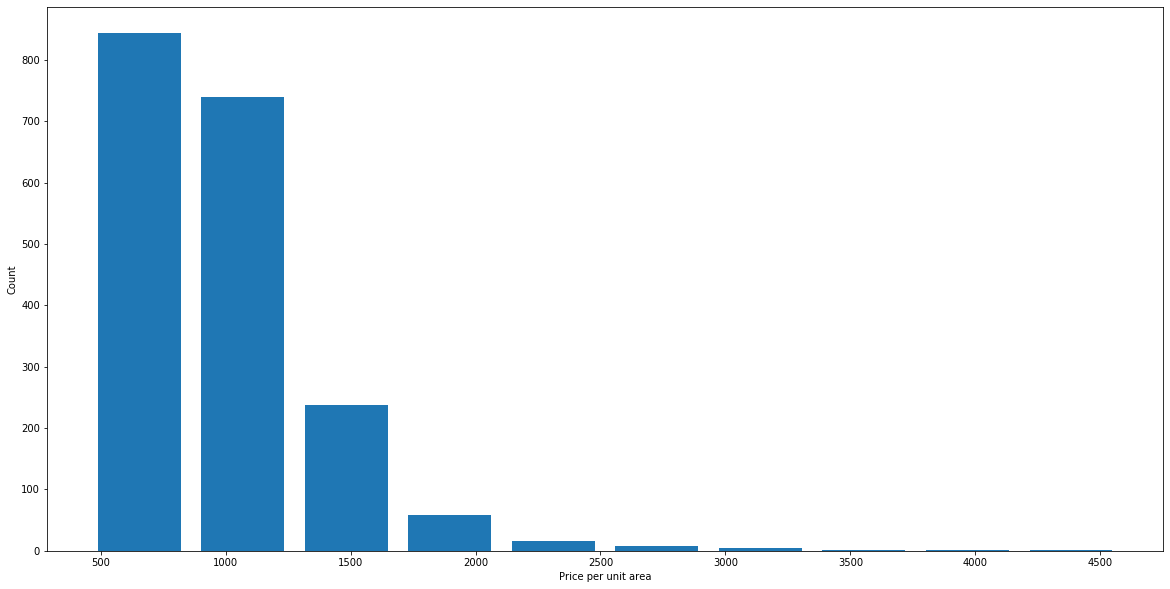

In [51]:
import matplotlib

matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df2.price_per_sqft, rwidth=0.8)
plt.xlabel('Price per unit area')
plt.ylabel('Count')

although distribution has a slight positive skew, the vast majority of data points still form a normal distribution

## Building and Tuning Models

let's first encode categorical features

In [52]:
dummies=pd.get_dummies(df2.Location)
dummies.head()

,101 Wood Lane,Barnes,Battersea,Belgravia,Belsize Park,Canary Wharf,Chelsea,Chiswick,Clerkenwell,Ealing,...,South Hackney,St John's Wood,St. John's Wood,Surbiton,Thames Ditton,Wandsworth,Westminster,Wimbledon,Woodford Green,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df3=pd.concat([df2, dummies.drop('other', axis='columns')],axis='columns')
df3.head()

,Price,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,price_per_sqft,101 Wood Lane,Barnes,Battersea,...,Shoreditch,South Hackney,St John's Wood,St. John's Wood,Surbiton,Thames Ditton,Wandsworth,Westminster,Wimbledon,Woodford Green
0,785000,590,1,1,1,101 Wood Lane,1330.508475,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,740000,579,1,1,1,101 Wood Lane,1278.065630,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,750000,580,1,1,1,101 Wood Lane,1293.103448,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1160000,861,2,2,2,101 Wood Lane,1347.270616,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,750000,579,1,1,1,101 Wood Lane,1295.336788,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df4=df3.drop('Location', axis='columns')
df4.head()

,Price,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,price_per_sqft,101 Wood Lane,Barnes,Battersea,Belgravia,...,Shoreditch,South Hackney,St John's Wood,St. John's Wood,Surbiton,Thames Ditton,Wandsworth,Westminster,Wimbledon,Woodford Green
0,785000,590,1,1,1,1330.508475,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,740000,579,1,1,1,1278.065630,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,750000,580,1,1,1,1293.103448,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1160000,861,2,2,2,1347.270616,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,750000,579,1,1,1,1295.336788,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
X = df4.drop(['Price'],axis='columns')
X.head()

,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,price_per_sqft,101 Wood Lane,Barnes,Battersea,Belgravia,Belsize Park,...,Shoreditch,South Hackney,St John's Wood,St. John's Wood,Surbiton,Thames Ditton,Wandsworth,Westminster,Wimbledon,Woodford Green
0,590,1,1,1,1330.508475,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,579,1,1,1,1278.065630,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,580,1,1,1,1293.103448,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,861,2,2,2,1347.270616,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,579,1,1,1,1295.336788,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
y=df4.Price

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [58]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8826830061833665

#### Let's now employ K-Fold cross validation to determine accuracy of this linear model

In [59]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84818065, 0.90886058, 0.90100606, 0.85532465, 0.88818879])

#### Let's also check the accuracy of other models, using gridseachCV

In [60]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.880355,{'normalize': True}
1,lasso,0.880335,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.919725,"{'criterion': 'mse', 'splitter': 'best'}"


Now that we know that from the models that we've tested the linear model is most accurate, let's define a simple function that makes use of this model and predicts apartament price

In [61]:
X.head()

,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,price_per_sqft,101 Wood Lane,Barnes,Battersea,Belgravia,Belsize Park,...,Shoreditch,South Hackney,St John's Wood,St. John's Wood,Surbiton,Thames Ditton,Wandsworth,Westminster,Wimbledon,Woodford Green
0,590,1,1,1,1330.508475,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,579,1,1,1,1278.065630,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,580,1,1,1,1293.103448,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,861,2,2,2,1347.270616,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,579,1,1,1,1295.336788,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
def predict_price(location,sqft,bed,bath):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bed
    x[2] = bath
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [87]:
predict_price('Battersea', 871, 3, 1)

258454908996968.66

since the dataset was not large enough, the model remains accurate for the cases when the number of bedrooms is greater than the number of bathrooms. 

#### Let's now export the model 

In [88]:
import pickle
with open('london_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)